In [1]:
import os

import geopandas as gpd

from sqlalchemy import create_engine

user = os.environ.get('DB_USER')
pwd = os.environ.get('DB_PWD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT')

In [2]:
db_connection_url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/built_env"
engine = create_engine(db_connection_url)

In [3]:
sql = f'SELECT * FROM openmap_buildings_200814'

df = gpd.read_postgis(sql, engine, geom_col='geometry')
df.shape

(14309868, 3)

In [4]:
auth = gpd.read_file('https://opendata.arcgis.com/datasets/7f83b82ef6ce46d3a5635d371e8a3e7c_0.geojson')

In [5]:
auth = auth.to_crs(df.crs)

In [6]:
df.geometry = df.centroid

In [7]:
inp, res = df.sindex.query_bulk(auth.geometry, predicate='intersects')

In [8]:
import numpy as np

u, c = np.unique(inp, return_counts=True)

In [9]:
auth.loc[u, 'counts'] = c

<AxesSubplot:>

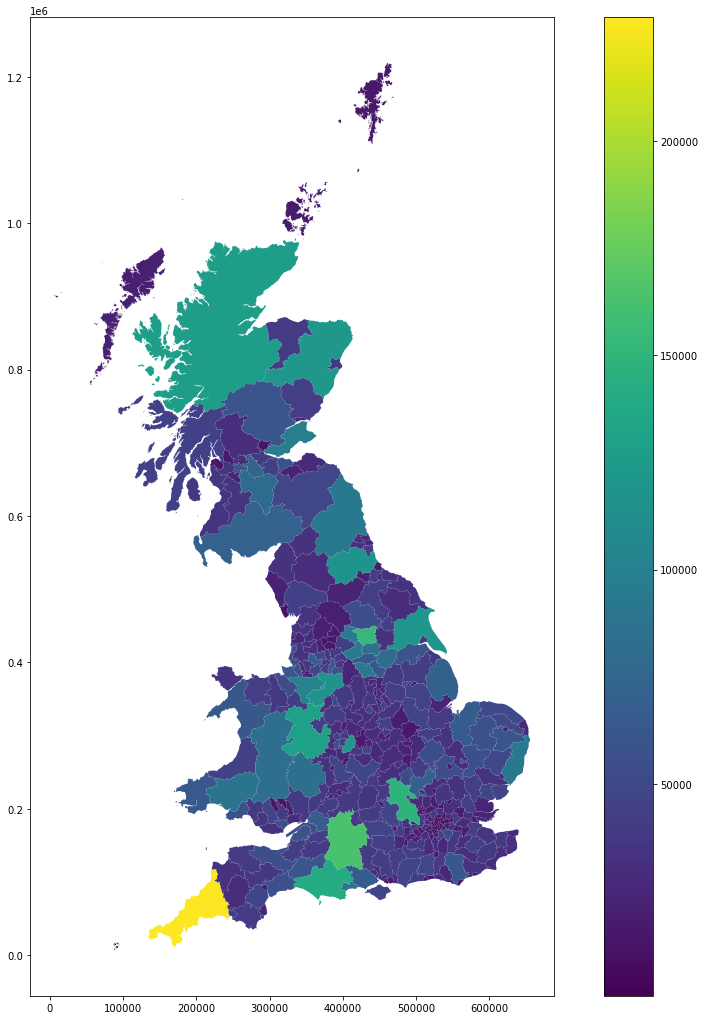

In [11]:
auth.plot('counts', figsize=(18, 18), legend=True)

In [12]:
auth.to_parquet('../../urbangrammar_samba/local_authorities.pq')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.


In [13]:
auth['counts'].describe()

count       368.000000
mean      38885.456522
std       26273.929125
min         484.000000
25%       23604.250000
50%       34107.500000
75%       43683.000000
max      228957.000000
Name: counts, dtype: float64

## Geo-chunking Local Authority Districts

On this section we will create a partition of the UK that groups spatially contiguous local authorities (LADs) in *regions* that have similar number of buildings. For that, we will employ a regionalisation algorithm that instead of requiring the number of regions uses a floor threshold for the minimum number of building counts and tries to generate groups _around_ that number (but above).

In [123]:
import pandas
import geopandas
import numpy as np
from mapclassify import greedy
from copy import deepcopy
from libpysal.weights import Queen, KNN, W

In [80]:
auth = geopandas.read_parquet("local_authorities.pq")

Note that we need to install [`region`](https://github.com/pysal/region) for this operation. The library is not part of `gds_env:5.0` as it has been phased out in benefit of [`spopt`](https://github.com/pysal/spopt), which will eventually be part of PySAL.

In [4]:
#! pip install region
import region

### Data

We currently only have building counts for GB:

<AxesSubplot:>

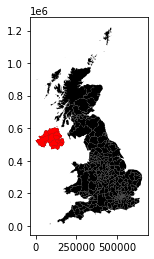

In [63]:
ax = auth.plot(color="k")
auth.loc[auth["counts"].isna(), :].plot(color="red", ax=ax)

So, for now, we will remove Northern Ireland for this regionalisation:

In [81]:
auth = auth.dropna().reset_index()

### Topology: `W`

To be able to build spatially constrained clusters, we need a way to capture topological relationships between local authorities. Spatial weights matrices come to the rescue here. Ideally, we need one that will give us contiguity relationships, but also that connects _every_ observation. In a geography like ours, this must come from a combination of more than one criterium.

Our starting point is based on queen contiguity:

In [82]:
%time w_queen = Queen.from_dataframe(auth)

CPU times: user 1min 23s, sys: 2.7 s, total: 1min 26s
Wall time: 1min 25s


/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: 43, 49, 319, 326, 328, 346.
  warnings.warn(message)


This produces a matrix with six islands -observations with no neighbors. To connect these to the rest of the graph, we are going to generate a nearest neighbor matrix, and use it for islands.

In [83]:
%time w_k1 = KNN.from_dataframe(auth, k=1)

CPU times: user 851 ms, sys: 4.04 ms, total: 855 ms
Wall time: 857 ms


/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 83 disconnected components.
  warnings.warn(message)


Our resulting matrix will be a queen contiguity one with islands connected to their nearest neighbor (and viceversa, for symmetry).

In [84]:
neighbors = deepcopy(w_queen.neighbors)
for i in w_queen.islands:
    j = w_k1.neighbors[i][0]
    neighbors[i] = [j]
    neighbors[j].append(i)
w = W(neighbors)

And we are ready to regionalise!

### Regionalisation

The Max-P algorithms requires four hyper-parameters:

1. Topology: we'll use `w`
1. Non-spatial features: to help the compactness of the regions, we will use the coordinates of each polygon's centroid
1. A variable to guide the number of regions (`spatiall_extensive_attr`): we will use the building count (`counts`) in `auth` with a flipped sign
1. A floor `threshold` to ensure no region has at least that value of the `spatiall_extensive_attr`: following our estimates for Dask performance, we will use a maximum number of 200,000 (-200,000)

First, let's pull out centroid coords:

In [85]:
cents = auth.geometry.centroid
xys = pandas.DataFrame({"X": cents.x,
                        "Y": cents.y
                       }, index=auth.index
                      )

And we can set up and run the optimisation. We are specifying that areas have a minimum of 100,000 buildings. By the nature of MaxP, it will try to create clusters _roughly_ that amount, but the only guarantee is to be above the floor threshold. This is a relatively fast run:

In [132]:
%%time
from region.max_p_regions.heuristics import MaxPRegionsHeu
model = MaxPRegionsHeu(random_state=123445)
model.fit_from_w(w, 
                 xys.values, 
                 spatially_extensive_attr=auth["counts"].values, 
                 threshold=100000
                )

CPU times: user 57.5 s, sys: 84.6 ms, total: 57.6 s
Wall time: 57.4 s


---

**NOTE**: I tried the following config which I _interpret_ to impose two restrictions, a floor and a ceiling, but discarded it as the results are not significantly better and running time is considerably higher and the upper limit does not seem to apply.

In [130]:
%%time
from region.max_p_regions.heuristics import MaxPRegionsHeu
model = MaxPRegionsHeu(random_state=123445)
model.fit_from_w(w, 
                 xys.values, 
                 spatially_extensive_attr=auth[["counts"]].assign(neg_counts=-auth["counts"]).values, 
                 threshold=np.array([150000, -200000])
                )

CPU times: user 57min 51s, sys: 841 ms, total: 57min 52s
Wall time: 57min 51s


---

The resulting labels can be further explored:

In [133]:
sizes = auth.groupby(model.labels_)["counts"].sum()
print((f"There are {pandas.Series(model.labels_).unique().shape[0]} regions"\
       f" and {sizes[sizes>200000].shape[0]} are above 200,000 buildings"))

There are 103 regions and 11 are above 200,000 buildings


Number of LADs per region and the number of buildings they include:

In [136]:
g = auth.groupby(model.labels_)
region_stats = pandas.DataFrame({"n_lads": g.size(),
                                 "n_buildings": g["counts"].sum()
                                })
region_stats.describe().T

,count,mean,std,min,25%,50%,75%,max
n_lads,103.0,3.572816,1.280333,1.0,3.0,3.0,4.0,12.0
n_buildings,103.0,138930.563107,35537.366693,100123.0,114334.5,128942.0,149196.0,256398.0


Distribution of number of buildings by region:

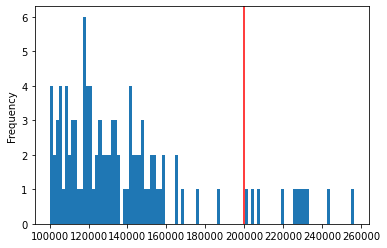

In [138]:
ax = region_stats["n_buildings"].plot.hist(bins=100)
ax.axvline(200000, color="red")

And the spatial layout of the regions:

<AxesSubplot:>

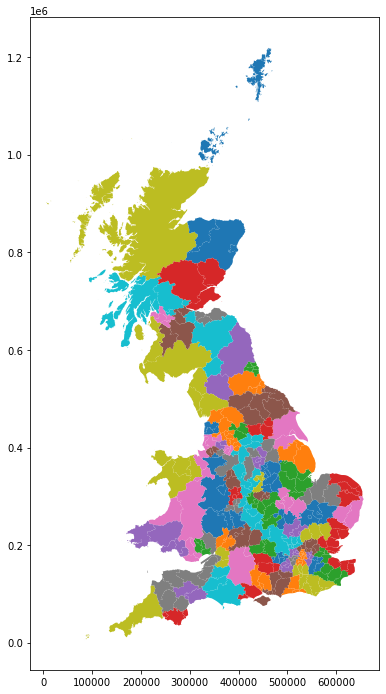

In [139]:
auth.assign(lbls=model.labels_)\
    .plot(column="lbls",
          categorical=True,
          figsize=(12, 12)
         )

### Writing labels out

In [141]:
auth.assign(lbls=model.labels_)[["lad20cd", "lbls"]].to_csv("chunking_labels.csv")